In [1]:
from mpes import fprocessing as fp, analysis as aly, visualization as vis, base as b
from symmetrize import sym, tps, pointops as po
import matplotlib.pyplot as plt
import numpy as np

from imp import reload
reload(aly)
reload(fp)
reload(b)

<module 'mpes.base' from '/home/metis/venv/conda3/lib/python3.7/site-packages/mpes/base.py'>

### 3.1 Correction of symmetry distortion using thin plate spline
#### 3.1.0 Retrieve experimental data

In [5]:
fdir = r'../data/data_114_parts'
parp = fp.parallelHDF5Processor(folder=fdir + r'/splits')
parp.gather(identifier=r'/*.h5', file_sorting=True)
len(parp.files)

50

In [6]:
axes = ['X', 'Y', 't']
bins = [100, 100, 100]
ranges = [(300, 1800), (200, 1800), (68000, 74000)]
parp.viewEventHistogram(fid=0, ncol=2, axes=axes, bins=bins, ranges=ranges, backend='bokeh')

In [7]:
axes = ['X', 'Y', 't']
bins = [512, 512, 50]
# IMPORTANT: Keep the bin ranges of the whole detector in X/Y (0,2047)
ranges = [(0, 2047), (0, 2047), (69000, 70000)]
parp.parallelBinning(axes=axes, nbins=bins, ranges=ranges, scheduler='threads', ret=False)

100%|██████████| 3/3 [01:00<00:00, 20.24s/it]


In [8]:
V = parp.combinedresult['binned']
V.shape

(512, 512, 50)

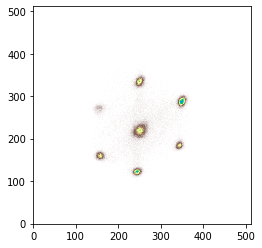

In [9]:
#%matplotlib inline
Eslice = V[:, :, 0:22].sum(axis=(2))
plt.imshow(Eslice, origin='lower', cmap='terrain_r')
#%matplotlib inline

#### 3.1.1 Calculate coordinate deformation from selected or detected landmarks and their symmetric correspondences

In [10]:
mc = aly.MomentumCorrector(V[ :, :, :], rotsym=6)

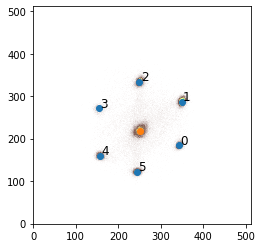

In [11]:
mc.selectSlice2D(selector=slice(0, 22), axis=2)
mc.featureExtract(image=mc.slice, method='daofind', sigma=10, fwhm=20)
mc.view(image=mc.slice, annotated=True, points=mc.features)

In [12]:
# potential scale adjustments for tetragonal lattices
mc.ascale = np.array([1, 1, 1, 1, 1, 1, 1])

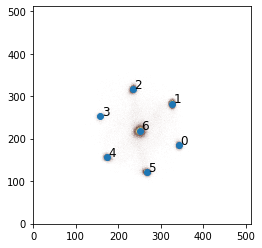

In [13]:
mc.splineWarpEstimate(image=mc.slice, landmarks=mc.pouter_ord, include_center=True, fixed_center=True,
                      iterative=False, interp_order=1, update=True)
mc.view(image=mc.slice_transformed, annotated=True, points={'feats':mc.ptargs})

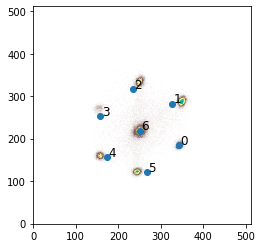

In [14]:
mc.view(image=mc.slice, annotated=True, points={'feats':mc.ptargs})

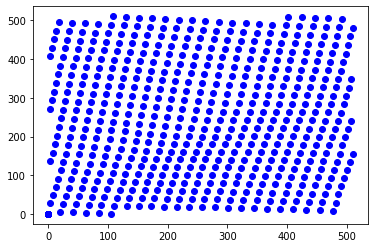

In [15]:
subs = 20
plt.scatter(mc.cdeform_field[::subs,::subs].ravel(), mc.rdeform_field[::subs,::subs].ravel(), c='b')

#### 3.1.2 Pose adjustment
Options to adjust scaling, rotation and translation, if needed. When the transform is desired, set `keep=True`

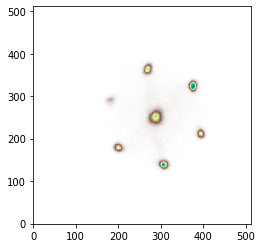

In [16]:
mc.coordinateTransform(image=mc.slice_transformed, type='scaling', xscale=1.15, yscale=1.15, keep=True)
mc.view(image=mc.slice_transformed)

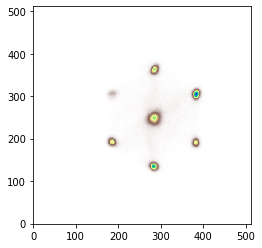

In [17]:
mc.coordinateTransform(image=mc.slice_transformed, type='rotation', angle=-10, center=(270, 270), keep=True)
mc.view(image=mc.slice_transformed)

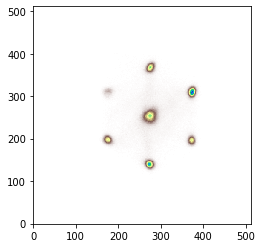

In [18]:
mc.coordinateTransform(image=mc.slice_transformed, type='translation', xtrans=-10, ytrans=5, keep=True)
mc.view(image=mc.slice_transformed)

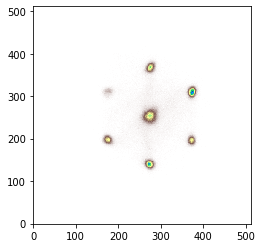

In [19]:
# Recalculate corrected image
import scipy.ndimage as ndi
mc.slice_transformed = ndi.map_coordinates(mc.slice, [mc.rdeform_field,mc.cdeform_field], order=1)
mc.view(image=mc.slice_transformed)

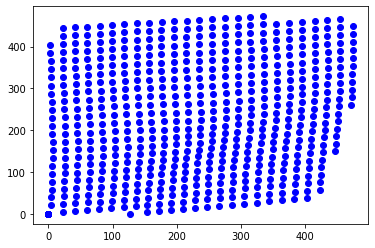

In [20]:
subs = 20
plt.scatter(mc.cdeform_field[::subs,::subs].ravel(), mc.rdeform_field[::subs,::subs].ravel(), c='b')

#### 3.1.3 Bin in converted grid

In [21]:
dfp = fp.dataframeProcessor(datafolder=fdir + r'/splits')
dfp.read(source='folder', ftype='h5')

In [23]:
# Apply the correction to the data frame
dfp.applyKCorrection(type='tps_matrix', rdeform_field = mc.rdeform_field, cdeform_field = mc.cdeform_field, X='X', Y='Y', newX='Xm', newY='Ym')

Calculating inverse Deformation Field, might take a moment...


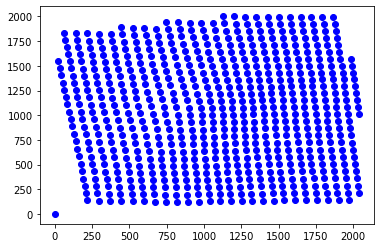

In [24]:
# The inverse displacement field is stored in dfp.dfield
dfield = dfp.dfield
subs =70
plt.scatter(dfield[0,::subs,::subs].ravel(), dfield[1,::subs,::subs].ravel(), c='b')

In [25]:
# Once you have calculated the inverse dfield, you can also call the applyKCorrection with that dfield directly, which is much quicker
# The x/y/newX/newY parameters can be ommited, then the defaults are taken (see above)
dfp = fp.dataframeProcessor(datafolder=fdir + r'/splits')
dfp.read(source='folder', ftype='h5')
dfp.applyKCorrection(type='tps_matrix', dfield = dfield)

In [26]:
# same binning ranges without jittering for comparison
axes = ['Xm', 'Ym', 't']
bins = [512, 512, 50]
ranges = [(0, 2047), (0, 2047), (69000, 70000)]
dfp.distributedBinning(axes=axes, nbins=bins, ranges=ranges, scheduler='threads', ret=False, jittered=True)

100%|██████████| 3/3 [01:19<00:00, 26.61s/it]


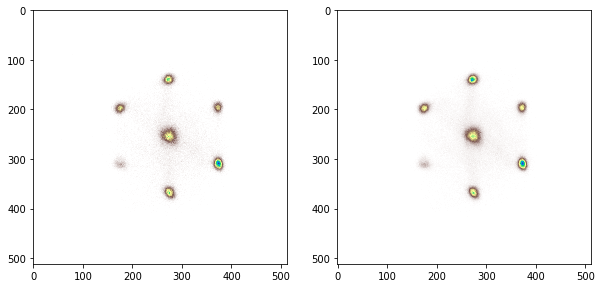

In [27]:
Eslice_rebinned = dfp.histdict['binned'][:, :, 0:22].sum(axis=(2))
plt.figure(figsize=(10, 6))
plt.subplot(1,2,1)
plt.imshow(Eslice_rebinned, cmap='terrain_r')
plt.subplot(1,2,2)
plt.imshow(mc.slice_transformed, cmap='terrain_r')

In [28]:
# new Histogram function that can also look at the transformed columns
axes = ['Xm', 'Ym', 't']
bins = [100, 100, 100]
ranges = [(300, 1800), (200, 1800), (68000, 74000)]
dfp.viewEventHistogram(dfpid=0, ncol=2, axes=axes, bins=bins, ranges=ranges, backend='bokeh')

In [29]:
# reasonable binning ranges, with jittering
axes = ['Xm', 'Ym', 't']
bins = [300, 300, 500]
ranges = [(300, 1800), (300, 1800), (69000, 75000)]
dfp.distributedBinning(axes=axes, nbins=bins, ranges=ranges, scheduler='threads', ret=False, jittered=True)

100%|██████████| 3/3 [01:19<00:00, 26.36s/it]


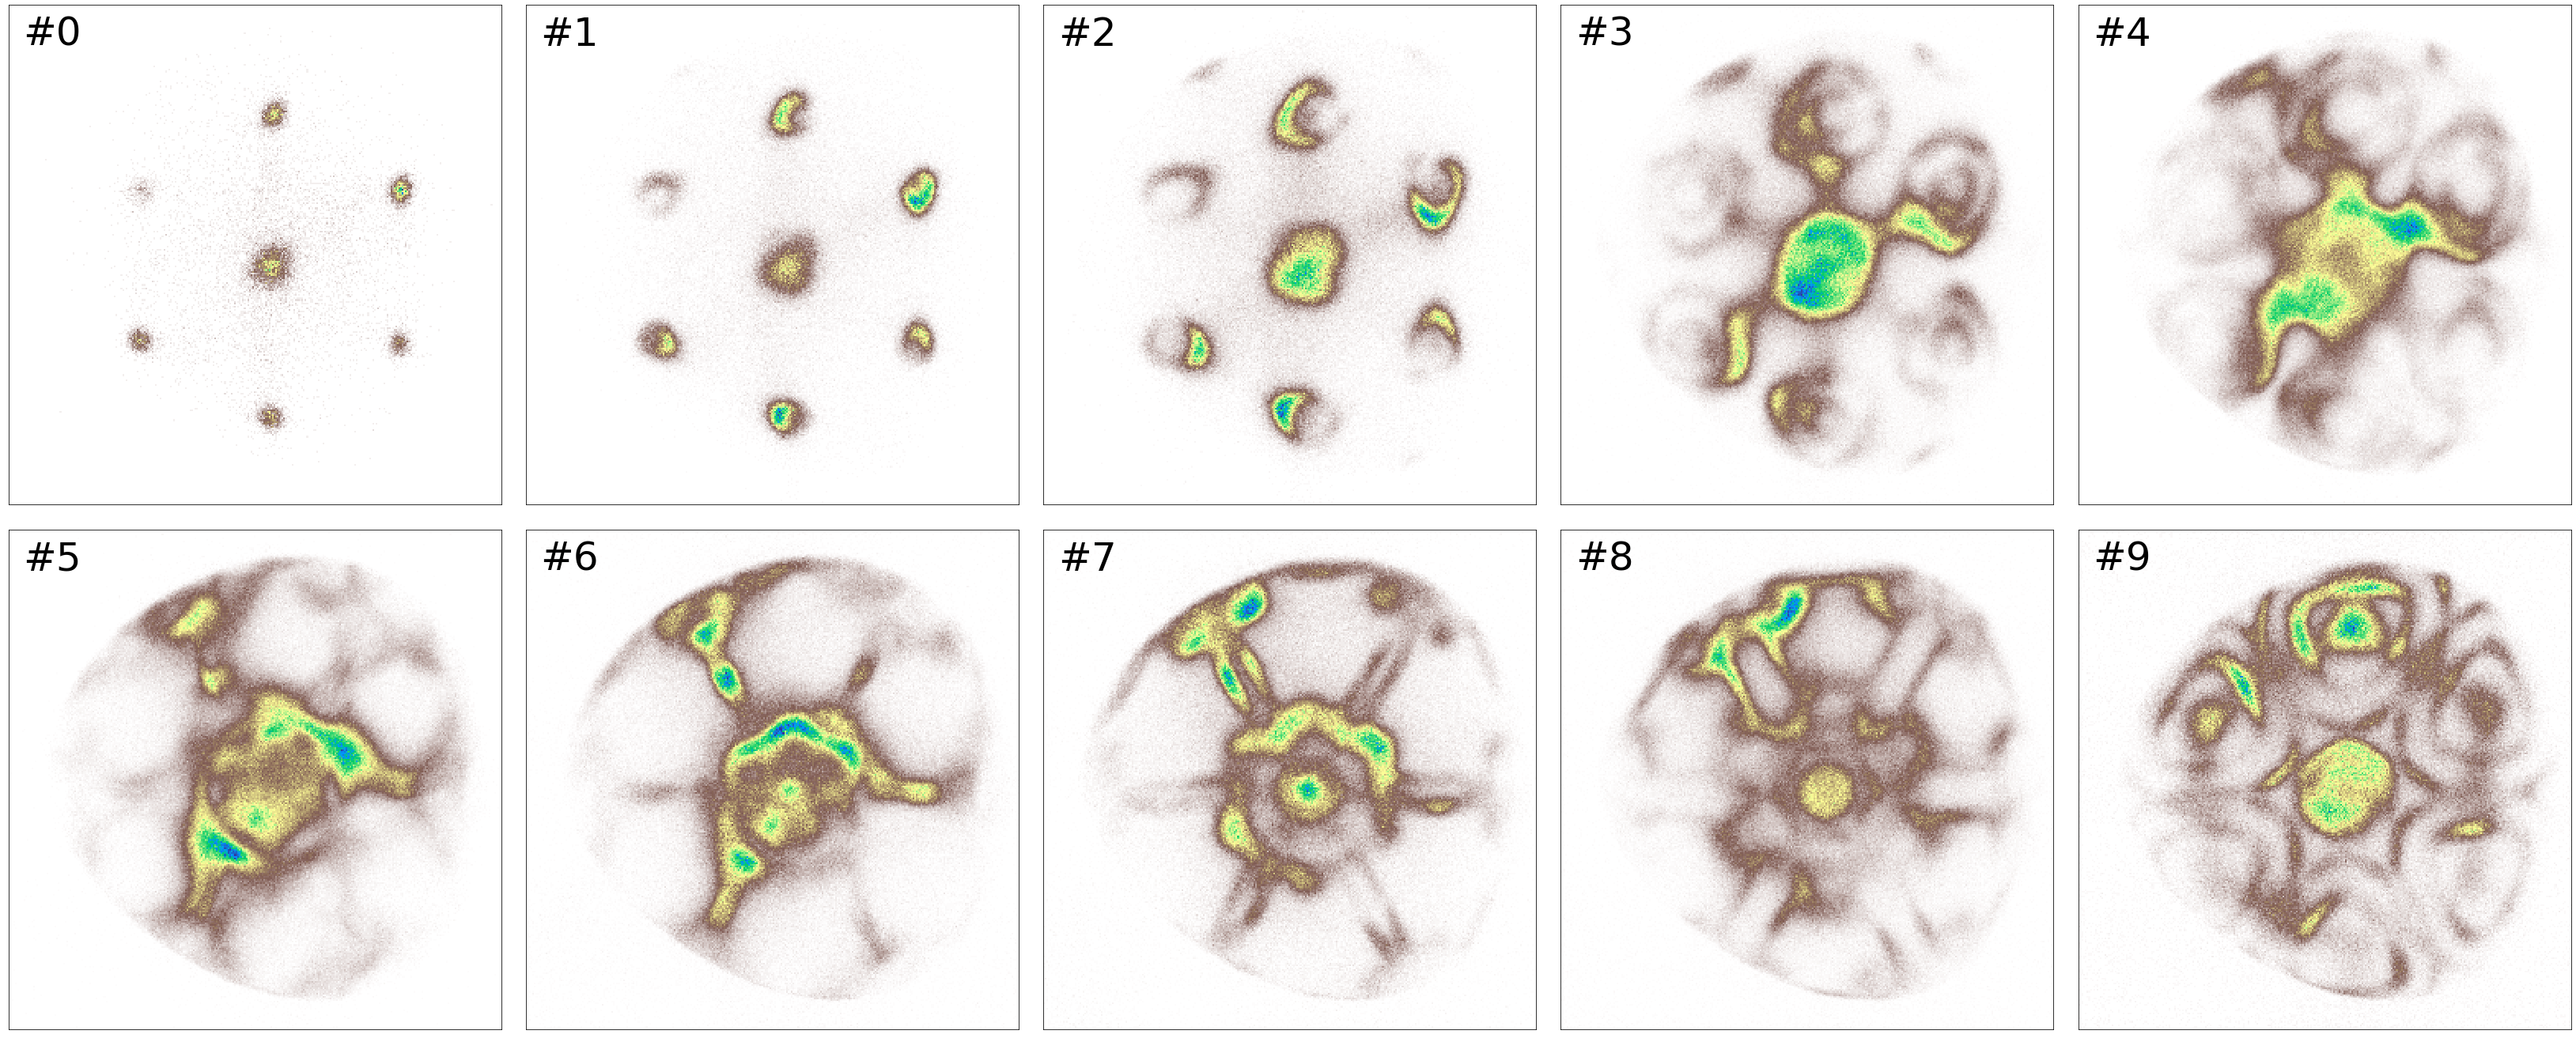

In [35]:
sliceid = [30, 40, 50, 65, 75, 90, 100, 120, 140, 180]
vis.sliceview3d(dfp.histdict['binned'][...,sliceid], axis=2, ncol=5, colormap='terrain_r', numsize=50);